In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# import backtrader as bt
import datetime

In [33]:
#df = pd.read_csv("../raw_data/merged_data_THETAModel.csv")
#df.dropna(inplace=True)
#df

In [34]:
# Load daily data with predictions

df_pred = pd.read_csv("../data/predictions/merged_data_arima_model.csv")
df_pred = df_pred.dropna()
df_pred.drop(columns=['Unnamed: 0'], inplace=True)
df_pred['timestamp'] = pd.to_datetime(df_pred['timestamp'])
df_pred.head(10)

,timestamp,open,high,low,close,volat_ATR,predictions
0,2023-01-02,16610.4,16799.0,16541.2,16666.0,348.494688,16610.3
1,2023-01-03,16665.9,16774.0,16600.3,16667.2,336.009353,16666.0
2,2023-01-04,16667.3,16984.6,16645.7,16842.1,336.215828,16667.2
3,2023-01-05,16842.2,16872.8,16740.4,16823.8,321.657555,16842.1
4,2023-01-06,16823.8,17030.0,16664.8,16943.8,324.767729,16823.8
5,2023-01-07,16943.9,16973.6,16900.1,16936.5,306.820034,16943.8
6,2023-01-08,16936.5,17181.1,16905.0,17124.7,304.625746,16936.5
7,2023-01-09,17124.6,17387.8,17098.2,17169.7,303.552479,17124.7
8,2023-01-10,17169.6,17485.4,17140.4,17428.8,306.513016,17169.7
9,2023-01-11,17428.8,18013.2,17306.4,17935.7,335.104943,17428.8


In [35]:
# Load 1h data for back-testing

df_true = pd.read_csv('../data/raw_data/BTCUSDT_1h.csv')
df_true = df_true.drop(columns=['open', 'close', 'volume'])
df_true = df_true[(df_true['timestamp'] > '2023-01-02') & (df_true['timestamp'] < '2023-06-04')]
df_true['timestamp'] = pd.to_datetime(df_true['timestamp'])
df_true['timestamp'] = df_true['timestamp'] - pd.Timedelta(hours=3)
df_true['timestamp_day'] = df_true['timestamp'].dt.floor('D')

df_true[df_true['timestamp_day'] == '2023-01-08']

,timestamp,high,low,timestamp_day
29229,2023-01-08 00:00:00,16949.3,16905.0,2023-01-08
29230,2023-01-08 01:00:00,16930.0,16908.6,2023-01-08
29231,2023-01-08 02:00:00,16927.4,16912.3,2023-01-08
29232,2023-01-08 03:00:00,16939.5,16923.2,2023-01-08
29233,2023-01-08 04:00:00,16939.4,16930.0,2023-01-08
29234,2023-01-08 05:00:00,16937.2,16929.3,2023-01-08
29235,2023-01-08 06:00:00,16945.9,16927.5,2023-01-08
29236,2023-01-08 07:00:00,16947.5,16938.1,2023-01-08
29237,2023-01-08 08:00:00,16949.9,16933.0,2023-01-08
29238,2023-01-08 09:00:00,16960.0,16918.4,2023-01-08


In [36]:
# Initial capital
trade_amount = 1000

sell_threshold = 0.002 # 0.2% change in market drives decision making
buy_cost = 0.0001 # 0.01 %
sell_cost = 0.0005 # 0.05 %

trade_results = {
    'day': [], 
    'balance': [],
    'trade_type': [],
    'success': []
}

def helper_append(results, day, balance, trade_type, success) -> dict:
    '''Helper Function for appending results to dictionary'''
    results['day'].append(day)
    results['balance'].append(balance)
    results['trade_type'].append(trade_type)
    results['success'].append(success)
    return results

for _, row_day in df_pred.iterrows():
    
    # Params for each row for each day
    day_stamp = row_day['timestamp']
    day_open = row_day['open']
    day_close_true = row_day['close']
    day_close_pred = row_day['predictions']
    day_volat_atr = row_day['volat_ATR']
    
    short_stop_threshold = day_open + day_volat_atr
    long_stop_threshold = day_open - day_volat_atr
    
    ### Short Trade - betting the market will go down
    if day_open > day_close_pred:
        # Apply buy_cost
        trade_amount = trade_amount * (1 - buy_cost)
        
        # iterate over every hour in the day:
        for _, row_hour in df_true[df_true['timestamp_day'] == day_stamp].iterrows():
            # Hourly params for analyis
            hour_low_value = row_hour['low']
            hour_high_value = row_hour['high']
            hour_stamp = row_hour['timestamp']

            # if market drops 0.2% below day_open - sell to win
            if hour_low_value <= day_open * (1 - sell_threshold):
                # Update balance and apply sell_cost
                # TODO: check value
                trade_amount = trade_amount * (1 / (1 - sell_threshold)) * (1 - sell_cost)

                # Append results to dict
                trade_results = helper_append(trade_results, day_stamp, trade_amount, 'short', 'win')
                
                # Print
                print(f'day: {day_stamp} - type: {"short": <5} - win  at {hour_stamp.hour: >2} - balance: {trade_amount: 0.2f}')
                break
                
            # If market rises above short_stop_threshold
            elif hour_high_value >= short_stop_threshold:
                # Update balance and apply sell_cost
                trade_amount = trade_amount * (1 - (day_volat_atr / day_open)) * (1 - sell_cost)
                
                # Append results to dict
                trade_results = helper_append(trade_results, day_stamp, trade_amount, 'short', 'lose')
                print(f'day: {day_stamp} - type: {"short": <5} - lose at {hour_stamp.hour: >2} - balance: {trade_amount: 0.2f}')
                break
                
            # If market doesn't meet win/lose condition in 24 hours
            if hour_stamp.hour == 23:
                # Update balance and apply sell_cost
                trade_amount = trade_amount * (day_close_true / day_open) * (1 - sell_cost)
                
                # Append results to dict
                trade_results = helper_append(trade_results, day_stamp, trade_amount, 'short', 'exit')
                print(f'day: {day_stamp} - type: {"short": <5} - exit at {hour_stamp.hour: >2} - balance: {trade_amount: 0.2f}')
                
    ### Long Trade - betting the market will go up
    elif day_close_pred > day_open:
        # Apply buy_cost
        trade_amount = trade_amount * (1 - buy_cost)
        
        # iterate over every hour in the day:
        for _, row_hour in df_true[df_true['timestamp_day'] == day_stamp].iterrows():
            # Hourly params for analyis
            hour_low_value = row_hour['low']
            hour_high_value = row_hour['high']
            hour_stamp = row_hour['timestamp']
            
            # If market rises 0.2% above day_open - exit to win
            if hour_high_value > day_open * (1 + sell_threshold):
                # Update balance and apply sell cost
                trade_amount = trade_amount * (1 + sell_threshold) * (1 - sell_cost)
                
                # Append results to dict
                trade_results = helper_append(trade_results, day_stamp, trade_amount, 'long', 'win')
                print(f'day: {day_stamp} - type: {"long": <5} - win  at {hour_stamp.hour: >2} - balance: {trade_amount: 0.2f}')
                break
            
            # if market drops below long_stop_threshold
            elif hour_low_value <= long_stop_threshold:
                # Update balance and apply sell cost
                trade_amount = trade_amount * (1 - (day_volat_atr / day_open)) * (1 - sell_cost)
                
                # Append results to dict 
                trade_results = helper_append(trade_results, day_stamp, trade_amount, 'long', 'lose')
                print(f'day: {day_stamp} - type: {"long": <5} - lose at {hour_stamp.hour: >2} - balance: {trade_amount: 0.2f}')
                break                 
            
            # If market doesn't meet win/lose condition in 24 hours
            if hour_stamp.hour == 23:
                # Update balance and apply sell_cost
                trade_amount = trade_amount * (day_close_true / day_open) * (1 - sell_cost)
                
                # Append results to dict
                trade_results = helper_append(trade_results, day_stamp, trade_amount, 'long', 'exit')
                print(f'day: {day_stamp} - type: {"long": <5} - exit at {hour_stamp.hour: >2} - balance: {trade_amount: 0.2f}')
            
    ### Else skip speculation for that day (day_open == pred_close)
    else:
        trade_results = helper_append(trade_results, day_stamp, trade_amount, 'skip', 'skip')
        print(f'day: {day_stamp} - type: {"skip": <5} - balance: {trade_amount: 0.2f}')

day: 2023-01-02 00:00:00 - type: short - win  at  0 - balance:  1001.40
day: 2023-01-03 00:00:00 - type: long  - win  at  0 - balance:  1002.80
day: 2023-01-04 00:00:00 - type: short - exit at 23 - balance:  1012.71
day: 2023-01-05 00:00:00 - type: short - win  at  1 - balance:  1014.13
day: 2023-01-06 00:00:00 - type: skip  - balance:  1014.13
day: 2023-01-07 00:00:00 - type: short - win  at 10 - balance:  1015.56
day: 2023-01-08 00:00:00 - type: skip  - balance:  1015.56
day: 2023-01-09 00:00:00 - type: long  - win  at  0 - balance:  1016.98
day: 2023-01-10 00:00:00 - type: long  - win  at  0 - balance:  1018.40
day: 2023-01-11 00:00:00 - type: skip  - balance:  1018.40
day: 2023-01-12 00:00:00 - type: long  - win  at  0 - balance:  1019.82
day: 2023-01-13 00:00:00 - type: short - win  at  0 - balance:  1021.25
day: 2023-01-14 00:00:00 - type: short - win  at  0 - balance:  1022.69
day: 2023-01-15 00:00:00 - type: skip  - balance:  1022.69
day: 2023-01-16 00:00:00 - type: skip  - bal

In [37]:
df_results = pd.DataFrame(trade_results)

In [38]:
df_results

,day,balance,trade_type,success
0,2023-01-02,1001.402856,short,win
1,2023-01-03,1002.803668,long,win
2,2023-01-04,1012.712732,short,exit
3,2023-01-05,1014.133422,short,win
4,2023-01-06,1014.133422,skip,skip
...,...,...,...,...
148,2023-05-30,1055.088484,short,win
149,2023-05-31,1056.564395,long,win
150,2023-06-01,1056.564395,skip,skip
151,2023-06-02,1056.564395,skip,skip


<Axes: xlabel='day', ylabel='balance'>

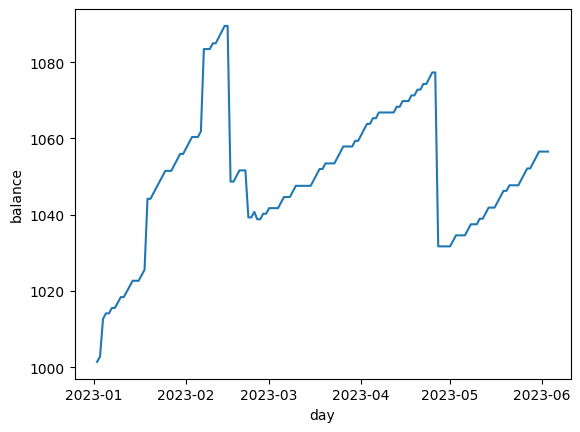

In [39]:
sns.lineplot(x=df_results['day'], y=df_results['balance'])

In [40]:
# Buy and hold
round(1000 * (df_pred["close"].iloc[-1] / df_pred["open"].iloc[0]), 2)

1628.79

In [41]:
df_results

,day,balance,trade_type,success
0,2023-01-02,1001.402856,short,win
1,2023-01-03,1002.803668,long,win
2,2023-01-04,1012.712732,short,exit
3,2023-01-05,1014.133422,short,win
4,2023-01-06,1014.133422,skip,skip
...,...,...,...,...
148,2023-05-30,1055.088484,short,win
149,2023-05-31,1056.564395,long,win
150,2023-06-01,1056.564395,skip,skip
151,2023-06-02,1056.564395,skip,skip


In [42]:
df_results.to_csv('../app/assets/ARIMA_Model_prediction_outcome.csv', index=False)